# Exploratory Analysis of Electricity Infraestructure in the Greek Islands (IPTO)


## 1. Description

**Objective:** This notebook performs an exploratory data analysis of electricity infraestructure data from the islands of Syros and Paros, provided by IPTO. The goal is to clean the data, identify  patterns, and understand the relationships between the different grid measurements.

**Analysis Structure:**
- Setup: Import libraries and define constants.
- Data Loading and Processing: Robust functions to read and structure the data for both islands.
- Analysis of Paros (P10):
    - Cleaning and handling of outliers and null values.
    - Correlation analysis and visualization of temporal patterns.
- Analysis of Syros (P40, P60, P70):
    - Similar analysis for the three measurement points in Syros.
    - Combined Analysis: Exploration of the key relationship between point P60 (Syros) and P10 (Paros), which are directly connected.

## 2. Environment Setup


### 2.1. Imports 
Loading all the necessary libraries for the analysis.


In [128]:
import pandas as pd
import glob
import os 
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display

sns.set_theme(style="whitegrid")



### 2.2. Constants

We define key paths and parameters as constants and import them from our YAML file.

In [97]:
CONFIG_PATH = '../../../config.yaml'

In [98]:
def load_config(config_path: str) -> dict:

    """
    Loads the configuration from a YAML file.
    
    Args:
        config_path (str): Path to the configuration file.

    Returns:
        dict: A dictionary with the configuration parameters.
    """

    try:
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        print(f"Configuration loaded successfully from '{config_path}'")
        return config
    except FileNotFoundError:
        print(f"Error: The configuration file '{config_path}' was not found.")
        return None
    except yaml.YAMLError as e:
        print(f"Error reading the YAML file: {e}")
        return None
    

config = load_config(CONFIG_PATH)

if config:
    BASE_DIR = config['1_analysis']['paths']['base_data_dir']
    
    FILE_PATH_PAROS = os.path.join(BASE_DIR, config['1_analysis']['paths']['paros_pattern'])
    FILE_PATH_SYROS = os.path.join(BASE_DIR, config['1_analysis']['paths']['syros_pattern'])
    
    SKIP_ROWS = config['1_analysis']['excel_settings']['skip_rows']

Configuration loaded successfully from '../../../config.yaml'


## 3. Data Loading and Processing

Here, we define the functions for loading and pre-processing the data.

In [130]:
def _load_data_from_files(file_pattern: str, skiprows: int) -> pd.DataFrame:
    """
    Finds, loads, and combines data from multiple Excel files into a single DataFrame.
    Args:
        file_pattern (str): Pattern to find files (e.g., "data/raw/Paros*.xlsx").
        skiprows (int): Number of initial rows to skip in each Excel file.

    Returns:
        pd.DataFrame: A single DataFrame with all the combined data.
        
    Raises:
        FileNotFoundError: If no files matching the pattern are found.
    """
    file_list = glob.glob(file_pattern)
    if not file_list:
        raise FileNotFoundError(f"No files found with pattern: {file_pattern}")

    print(f"{len(file_list)} files found:")
    for file_path in file_list:
        print(f"  -> {os.path.basename(file_path)}")
    print("-" * 50)

    # Load and concatenate all found files
    df_list = [pd.read_excel(filename, skiprows=skiprows) for filename in file_list]
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

In [131]:
def load_paros_data(file_pattern: str, skiprows: int) -> pd.DataFrame:
    """
    Loads and processes the Paros data from multiple Excel files.

    Args:
        file_pattern (str): Pattern to find the Paros files.
        skiprows (int): Rows to skip at the beginning of the files.

    Returns:
        pd.DataFrame: Processed DataFrame with a datetime index.
    """
    df_p10 = _load_data_from_files(file_pattern, skiprows=skiprows)
    
    # Clean column names and set a proper time index
    df_p10 = df_p10.rename(columns={'Hist Timestamp': 'hist_timestamp'})
    df_p10['hist_timestamp'] = pd.to_datetime(df_p10['hist_timestamp'], dayfirst=True)
    df_p10 = df_p10.set_index('hist_timestamp')
    
    # Remove the 'Date Key' column as it is redundant
    if 'Date Key' in df_p10.columns:
        df_p10 = df_p10.drop(columns=['Date Key'])
        
    return df_p10

In [124]:
def load_syros_data(file_pattern: str, skiprows: int) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Loads and splits the Syros data into separate DataFrames for each point (P40, P60, P70).
    Args:
        file_pattern (str): Pattern to find the Syros files.
        skiprows (int): Rows to skip at the beginning of the files.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: A tuple with the DataFrames for P40, P60, and P70.
    """
    combined_df = _load_data_from_files(file_pattern, skiprows=skiprows)
    
    # Programmatically generate column names for greater robustness
    base_metrics = ['AMP1', 'AMP2', 'AMP3', 'KVAB', 'KVBC', 'KVCA', 'MVAR', 'MW']
    points = ['P40', 'P60', 'P70']
    
    new_columns = ['Date Key', 'Hist Timestamp']
    for point in points:
        new_columns.extend([f"{metric}_{point}" for metric in base_metrics])
    
    combined_df.columns = new_columns

    # Convert the time column and set it as the index
    combined_df['Hist Timestamp'] = pd.to_datetime(combined_df['Hist Timestamp'], dayfirst=True)
    combined_df = combined_df.set_index('Hist Timestamp')

    # Helper function to create individual DataFrames
    def create_point_df(df: pd.DataFrame, point_suffix: str) -> pd.DataFrame:
        cols = ['Date Key'] + [col for col in df.columns if point_suffix in col]
        point_df = df[cols].copy()
        point_df.columns = point_df.columns.str.replace(point_suffix, '')
        if 'Date Key' in point_df.columns:
            point_df = point_df.drop(columns=['Date Key'])
        return point_df

    # Create a DataFrame for each measurement point
    df_p40 = create_point_df(combined_df, '_P40')
    df_p60 = create_point_df(combined_df, '_P60')
    df_p70 = create_point_df(combined_df, '_P70')

    return df_p40, df_p60, df_p70

In [141]:
def clean_and_unify_duplicates(df: pd.DataFrame, df_name: str) -> pd.DataFrame:
    """
    Finds duplicate timestamps in a DataFrame, displays them, and then
    unifies the values by averaging them to ensure a unique index.

    Args:
        df (pd.DataFrame): The input DataFrame to clean.
        df_name (str): The name of the DataFrame for display messages.

    Returns:
        pd.DataFrame: The cleaned DataFrame with a unique index.
    """
    # 1. Identify and display rows with the same timestamp
    is_duplicate_index = df.index.duplicated(keep=False)
    duplicate_rows = df[is_duplicate_index].sort_index()

    print(f"\n--- Checking for duplicates in DataFrame {df_name} ---")
    if not duplicate_rows.empty:
        print(f"The following rows with duplicate timestamps were found in {df_name}:")
        display(duplicate_rows)
    else:
        print(f"No rows with duplicate timestamps were found in {df_name}.")

    # 2. Unify rows by index by averaging their values
    # This ensures that each timestamp is unique, handling both duplicates and non-duplicates.
    rows_before = len(df)
    df_unified = df.groupby(df.index).mean()
    rows_after = len(df_unified)
    
    if rows_before > rows_after:
        print(f"{rows_before - rows_after} duplicate rows were unified in {df_name}.")
        print(f"Rows before: {rows_before} -> Rows after: {rows_after}")
    else:
        print("The index was already unique. No changes were made to the number of rows.")
        
    return df_unified

## 4. Exploratory Analysis: Paros Island (Point P10)

### 4.1. Initial Loading and Inspection

In [132]:
try:
    df_p10 = load_paros_data(FILE_PATH_PAROS, skiprows=SKIP_ROWS)
    
    print("\n--- First 5 rows of the Paros (P10) DataFrame ---")
    display(df_p10.head())
    
    print("\n--- DataFrame Info of the Paros (P10) DataFrame---")
    df_p10.info()

    print("\n--- DataFrame describe of the Paros (P10) DataFrame---")
    display(df_p10.describe())
    
except FileNotFoundError as e:
    print(f"Error: {e}")

2 files found:
  -> Paros_23A.xlsx
  -> Paros_23B-24.xlsx
--------------------------------------------------

--- First 5 rows of the Paros (P10) DataFrame ---


,AMP1,AMP2,AMP3,KVAB,KVBC,KVCA,MVAR,MW
hist_timestamp,,,,,,,,
2023-03-01 01:00:00,80.201507,79.332153,79.721191,157.99307,156.73771,156.52127,-20.268823,-7.255861
2023-03-01 01:01:00,80.201507,79.332153,79.721191,157.99307,156.73771,156.52127,-20.268823,-7.255861
2023-03-01 01:02:00,80.201507,79.332153,79.721191,157.99307,156.73771,156.52127,-20.268823,-7.255861
2023-03-01 01:03:00,80.201507,79.332153,79.721191,157.99307,156.73771,156.52127,-20.268823,-7.255861
2023-03-01 01:04:00,80.201507,79.332153,79.721191,157.99307,156.73771,156.52127,-20.268823,-7.255861



--- DataFrame Info of the Paros (P10) DataFrame---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 526500 entries, 2023-03-01 01:00:00 to 2024-02-29 23:59:00
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AMP1    526500 non-null  float64
 1   AMP2    526500 non-null  float64
 2   AMP3    526500 non-null  float64
 3   KVAB    526500 non-null  float64
 4   KVBC    526500 non-null  float64
 5   KVCA    526500 non-null  float64
 6   MVAR    526500 non-null  float64
 7   MW      526500 non-null  float64
dtypes: float64(8)
memory usage: 36.2 MB

--- DataFrame describe of the Paros (P10) DataFrame---


,AMP1,AMP2,AMP3,KVAB,KVBC,KVCA,MVAR,MW
count,526500.000000,526500.000000,526500.000000,526500.000000,526500.000000,526500.000000,526500.000000,526500.000000
mean,116.151511,115.791008,117.110611,155.388948,153.981163,154.275109,-19.191159,-22.575206
std,38.187473,39.102953,38.920039,4.268058,4.223601,4.219120,6.522955,12.474823
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-40.773983,-67.439476
25%,87.916580,87.251380,88.860794,154.764110,153.378370,153.754710,-22.780355,-30.070198
50%,103.207220,102.046270,103.120990,155.425580,154.001410,154.345930,-20.344451,-18.135362
75%,138.631720,138.746260,140.017150,156.205420,154.752500,155.045300,-17.546279,-13.083296
max,263.313720,265.244590,264.999810,161.236520,159.587060,160.218520,22.708427,0.001048


### 4.2. Cleaning Missing Data

In [138]:
df_p10_duplicates = df_p10.index[df_p10.index.duplicated(keep=False)].unique()

print("\n--- All duplicate rows found ---")
if not df_p10_duplicates.empty:
    print(df_p10_duplicates)
else:
    print("No completely duplicate rows were found.")


--- All duplicate rows found ---
No completely duplicate rows were found.


In [149]:
# Force a regular per-minute frequency to identify the gaps
df_p10_regular = df_p10.asfreq('min')
missing_values_count = df_p10_regular.isnull().sum().sum()

print(f"{missing_values_count} missing values were identified after regularizing the index to a 1-minute frequency.")

print(f"Rows before dropping nulls: {len(df_p10_regular)}")
df_p10 = df_p10_regular.dropna()
print(f"Rows after dropping nulls: {len(df_p10)}")

3840 missing values were identified after regularizing the index to a 1-minute frequency.
Rows before dropping nulls: 526980
Rows after dropping nulls: 526500


Upon inspecting the data frequency, we noticed it is not regular. This suggests the existence of missing timestamps.

Analysis of Missing Data:  
The gaps in the data are not random. They are mainly due to:
- Daylight Saving Time change: A 60-minute block of missing data on March 26, 2023.
- Technical shutdowns: A 60-minute block at midnight on August 31, 2023.
- Micro-interruptions: Sampling every 5 minutes instead of every minute during a period on December 29, 2023.

### 4.3. Correlation Analysis


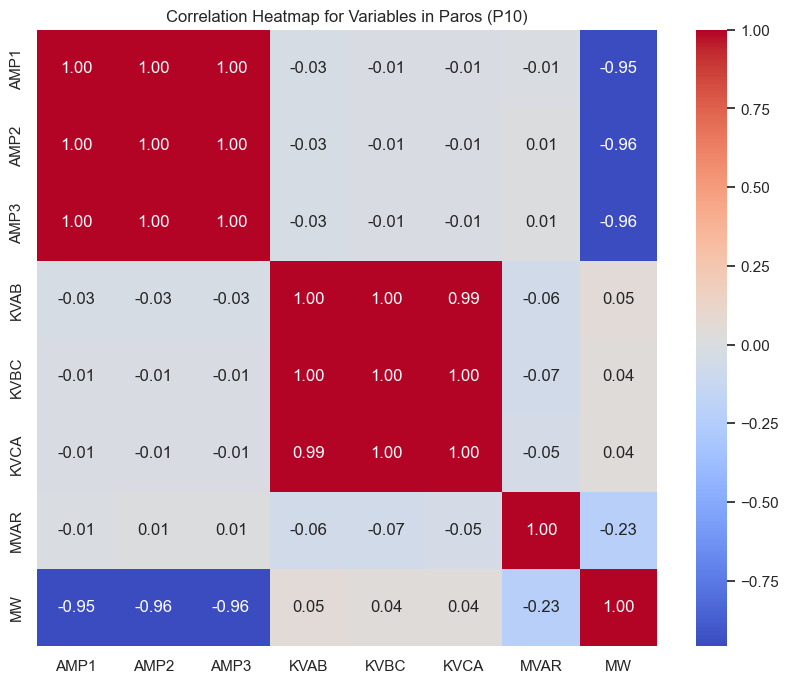

In [104]:
correlation_matrix = df_p10.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for Variables in Paros (P10)")
plt.show()

Correlation Conclusions:
- Power vs. Current: There is an almost perfect negative correlation (-0.95 and -0.96) between active power (MW) and the currents (AMP1, AMP2, AMP3). This is consistent: as current consumption increases, the generated power (which is negative by convention) also increases in magnitude.
- System Balance: The three currents (AMPs) and the three voltages (KVs) are almost perfectly correlated with each other (~1.00), indicating a stable and well-balanced three-phase system.
- Grid Stability: Voltage (KV) has a very low correlation with power and current. This suggests that the measurement point is connected to a robust electrical grid, where the voltage is not significantly affected by the plant's generation.

### 4.4. Temporal Pattern Analysis

We add time-based columns to analyze consumption patterns throughout the day, week, and year.


In [105]:
# Add temporal features for analysis
df_p10['hour'] = df_p10.index.hour
df_p10['day_of_week'] = df_p10.index.dayofweek  # Monday=0, Sunday=6
df_p10['month'] = df_p10.index.month

**Daily Consumption Pattern (MW)**

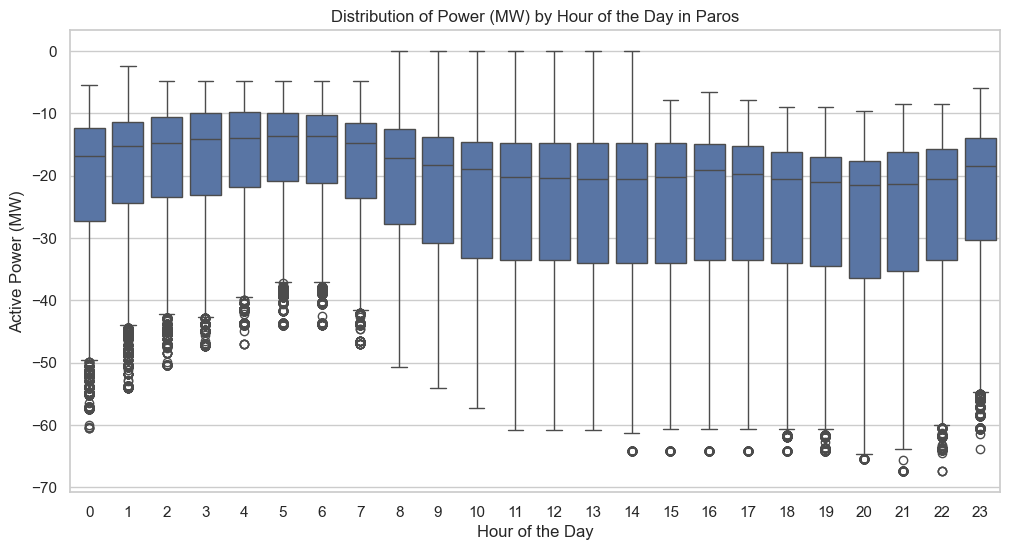

In [106]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='MW', data=df_p10)
plt.title("Distribution of Power (MW) by Hour of the Day in Paros")
plt.xlabel("Hour of the Day")
plt.ylabel("Active Power (MW)")
plt.show()

A clear daily pattern is observed: energy consumption is lower during the early morning hours and reaches its peak in the afternoon and evening. It's important to remember that in this dataset, consumption is represented by negative numbers. Therefore, as energy demand increases, the corresponding numerical value decreases (becomes more negative)

**Weekly Consumption Pattern (MW)**

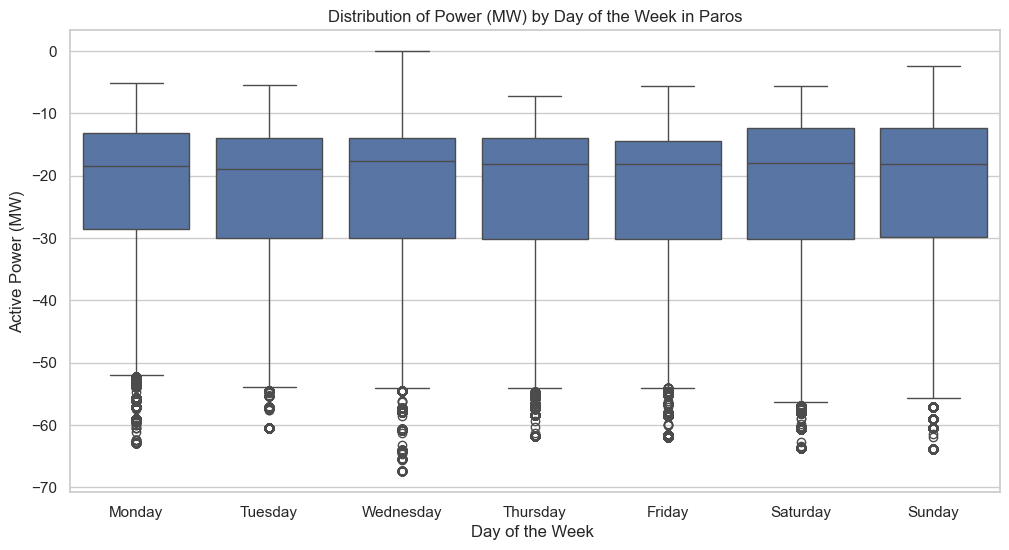

In [107]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='MW', data=df_p10)
plt.title("Distribution of Power (MW) by Day of the Week in Paros")
plt.xlabel("Day of the Week ")
plt.ylabel("Active Power (MW)")
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

Consumption is relatively constant during the week.

### 4.5. Seasonal Decomposition

To visualize the trend, seasonality, and noise components of the time series, we perform a seasonal decomposition on the daily aggregated data.


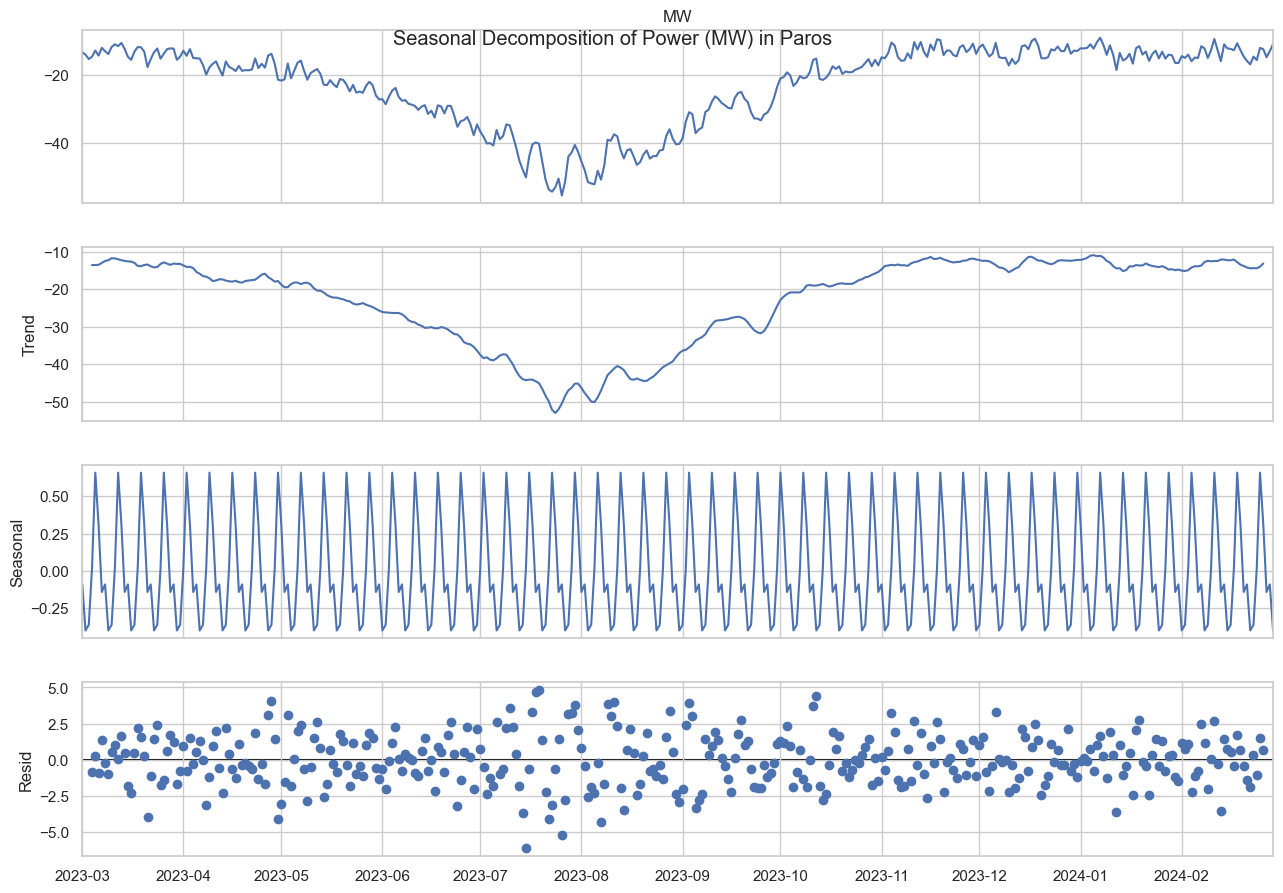

In [108]:
# Resample to a daily frequency for better visualization of seasonality
df_daily = df_p10['MW'].resample('D').mean()

# Perform additive decomposition with a weekly seasonality (period=7)
decomposition = seasonal_decompose(df_daily.dropna(), model='additive', period=7)

# Plot the components
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle("Seasonal Decomposition of Power (MW) in Paros", y=0.92)
plt.show()

Decomposition Analysis:
- Trend: Shows a clear increase in consumption during the summer months (June to September), reaching its maximum in August. This could be cause by the strong impact of seasonal tourism on the island.
- Seasonal: Reflects the weekly pattern we already observed, with consumption peaks towards the end of the week.
- Residuals (Resid): The residuals are relatively small and show no clear patterns, indicating that the additive model has captured the trend and seasonality well.

## 5. Exploratory Analysis: Syros Island (P40, P60, P70)


### 5.1. Initial Loading and Inspection

In [144]:
try:
    df_p40, df_p60, df_p70 = load_syros_data(FILE_PATH_SYROS, skiprows=SKIP_ROWS)
    
    print("\n--- First 5 rows of the Syros (P40) DataFrame ---")
    display(df_p40.head())

    print("\n--- P40 DataFrame Info ---")
    df_p40.info()

    print("\n--- P40 DataFrame Describe ---")
    display(df_p40.describe())

    print("\n--- First 5 rows of the Syros (P60) DataFrame ---")
    display(df_p60.head())

    print("\n--- P60 DataFrame Info ---")
    df_p60.info()

    print("\n--- P60 DataFrame Describe ---")
    display(df_p60.describe())

    print("\n--- First 5 rows of the Syros (P70) DataFrame ---")
    display(df_p70.head())
    
    print("\n--- P70 DataFrame Info ---")
    df_p70.info()

    print("\n--- P70 DataFrame Describe ---")
    display(df_p70.describe())
    

except FileNotFoundError as e:
    print(f"Error: {e}")

4 files found:
  -> Syros_23A.xlsx
  -> Syros_23B.xlsx
  -> Syros_23C.xlsx
  -> Syros_23D-24A.xlsx
--------------------------------------------------

--- First 5 rows of the Syros (P40) DataFrame ---


,AMP1,AMP2,AMP3,KVAB,KVBC,KVCA,MVAR,MW
Hist Timestamp,,,,,,,,
2023-03-01 01:00:00,51.358768,54.61737,51.889881,158.36398,157.38867,157.12745,-7.933085,-11.067237
2023-03-01 01:01:00,51.358768,54.61737,51.889881,158.36398,157.38867,157.12745,-6.531084,-11.067237
2023-03-01 01:02:00,51.358768,54.61737,51.889881,158.36398,157.38867,157.12745,-6.531084,-11.067237
2023-03-01 01:03:00,51.358768,54.61737,51.889881,158.36398,157.38867,157.12745,-6.531084,-11.067237
2023-03-01 01:04:00,51.358768,54.61737,51.889881,158.36398,157.38867,157.12745,-6.531084,-11.067237



--- P40 DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 529260 entries, 2023-03-01 01:00:00 to 2024-03-01 23:59:00
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AMP1    529260 non-null  float64
 1   AMP2    529260 non-null  float64
 2   AMP3    529260 non-null  float64
 3   KVAB    529260 non-null  float64
 4   KVBC    529260 non-null  float64
 5   KVCA    529260 non-null  float64
 6   MVAR    529260 non-null  float64
 7   MW      529260 non-null  float64
dtypes: float64(8)
memory usage: 36.3 MB

--- P40 DataFrame Describe ---


,AMP1,AMP2,AMP3,KVAB,KVBC,KVCA,MVAR,MW
count,529260.000000,529260.000000,529260.000000,529260.000000,529260.000000,529260.000000,529260.000000,529260.000000
mean,95.623100,93.717481,94.280809,156.395103,155.034050,155.328974,-7.517518,-17.905284
std,48.438246,47.644793,47.350441,4.404772,4.347424,4.346750,13.644490,15.459111
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-48.168647,-71.322784
25%,59.467464,57.847633,59.044849,155.815730,154.506920,154.842910,-17.158722,-26.311946
50%,90.920570,89.526390,89.921379,156.405160,155.030410,155.362830,-6.524712,-15.789744
75%,125.550207,123.436450,122.189620,157.090920,155.777080,156.067190,2.750060,-6.937474
max,582.593680,289.999140,308.543150,162.101940,160.353280,160.101980,43.339687,22.113641



--- First 5 rows of the Syros (P60) DataFrame ---


,AMP1,AMP2,AMP3,KVAB,KVBC,KVCA,MVAR,MW
Hist Timestamp,,,,,,,,
2023-03-01 01:00:00,35.59428,36.749645,35.739799,158.17517,157.28115,157.37725,2.508091,7.719392
2023-03-01 01:01:00,35.59428,36.749645,35.739799,158.17517,157.28115,157.37725,2.508091,7.719392
2023-03-01 01:02:00,35.59428,36.749645,35.739799,158.17517,157.28115,157.37725,2.508091,7.719392
2023-03-01 01:03:00,35.59428,36.749645,35.739799,158.17517,157.28115,157.37725,2.508091,7.719392
2023-03-01 01:04:00,35.59428,36.749645,35.739799,158.17517,157.28115,157.37725,2.508091,7.719392



--- P60 DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 529260 entries, 2023-03-01 01:00:00 to 2024-03-01 23:59:00
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AMP1    529260 non-null  float64
 1   AMP2    529260 non-null  float64
 2   AMP3    529260 non-null  float64
 3   KVAB    529260 non-null  float64
 4   KVBC    529260 non-null  float64
 5   KVCA    529260 non-null  float64
 6   MVAR    529260 non-null  float64
 7   MW      529260 non-null  float64
dtypes: float64(8)
memory usage: 36.3 MB

--- P60 DataFrame Describe ---


,AMP1,AMP2,AMP3,KVAB,KVBC,KVCA,MVAR,MW
count,529260.000000,529260.000000,529260.000000,529260.000000,529260.000000,529260.000000,529260.000000,529260.000000
mean,88.043333,89.433705,90.841839,156.402092,155.009467,155.338693,2.711443,22.758165
std,47.093006,47.846051,47.131114,4.288503,4.244765,4.240164,6.558022,12.709942
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-38.242240,0.000000
25%,52.788288,53.815444,55.766532,155.820610,154.453930,154.846320,1.366622,13.444800
50%,72.275703,73.090286,74.955924,156.371010,155.028760,155.387680,3.704596,18.283611
75%,116.125650,117.594900,118.582940,157.164350,155.734780,156.014670,6.311845,30.292032
max,406.580870,400.468710,355.383880,161.982860,160.770530,160.403420,56.566570,67.006248



--- First 5 rows of the Syros (P70) DataFrame ---


,AMP1,AMP2,AMP3,KVAB,KVBC,KVCA,MVAR,MW
Hist Timestamp,,,,,,,,
2023-03-01 01:00:00,137.96072,137.84271,135.28692,158.64616,157.3784,157.39758,-35.207832,-12.164355
2023-03-01 01:01:00,137.96072,137.84271,135.28692,158.64616,157.3784,157.39758,-35.207832,-12.164355
2023-03-01 01:02:00,137.96072,137.84271,135.28692,158.64616,157.3784,157.39758,-35.207832,-12.164355
2023-03-01 01:03:00,137.96072,137.84271,135.28692,158.64616,157.3784,157.39758,-35.207832,-12.164355
2023-03-01 01:04:00,137.96072,137.84271,135.28692,158.64616,157.3784,157.39758,-35.207832,-12.164355



--- P70 DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 529260 entries, 2023-03-01 01:00:00 to 2024-03-01 23:59:00
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AMP1    529260 non-null  float64
 1   AMP2    529260 non-null  float64
 2   AMP3    529260 non-null  float64
 3   KVAB    529260 non-null  float64
 4   KVBC    529260 non-null  float64
 5   KVCA    529260 non-null  float64
 6   MVAR    529260 non-null  float64
 7   MW      529260 non-null  float64
dtypes: float64(8)
memory usage: 36.3 MB

--- P70 DataFrame Describe ---


,AMP1,AMP2,AMP3,KVAB,KVBC,KVCA,MVAR,MW
count,529260.000000,529260.000000,529260.000000,529260.000000,529260.000000,529260.000000,529260.000000,529260.000000
mean,119.900651,117.393106,116.401316,156.417522,155.100393,155.460695,-17.454124,-18.564933
std,55.512335,55.111150,54.006952,4.065497,4.004820,4.022576,18.053388,15.718462
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-68.682456,-73.404853
25%,77.372741,75.184944,75.371070,155.815460,154.549940,154.989420,-29.408485,-27.226840
50%,116.105305,113.882860,112.418020,156.434210,155.104040,155.496990,-15.645404,-16.415592
75%,156.392630,153.633890,151.730222,157.120890,155.812280,156.204710,-4.047482,-7.510410
max,419.387960,408.680080,277.012900,161.739860,160.443140,160.700510,31.251659,21.587341


### 5.2.Duplicate Data

In [146]:
try:
    print("\n--- P40 DataFrame duplicate Data ---")
    df_p40 = clean_and_unify_duplicates(df_p40, "P40")

    print("\n--- P60 DataFrame duplicate Missing Data ---")
    df_p60 = clean_and_unify_duplicates(df_p60, "P60")

    print("\n--- P70 DataFrame duplicate Missing Data ---")
    df_p70 = clean_and_unify_duplicates(df_p70, "P70")


except NameError:
    print("Make sure you have loaded the Syros DataFrames before running this cell.")


--- P40 DataFrame duplicate Data ---

--- Checking for duplicates in DataFrame P40 ---
The following rows with duplicate timestamps were found in P40:


,AMP1,AMP2,AMP3,KVAB,KVBC,KVCA,MVAR,MW
Hist Timestamp,,,,,,,,
2023-12-01 01:00:00,129.400480,123.796980,125.696490,154.88458,153.64334,154.26834,-33.388839,-6.165730
2023-12-01 01:00:00,129.400480,123.796980,125.696490,154.88458,153.64334,154.26834,-33.388839,-6.165730
2023-12-01 01:01:00,131.811440,129.847930,125.696490,154.88458,153.64334,154.26834,-33.388839,-6.165730
2023-12-01 01:01:00,131.811440,129.847930,125.696490,154.88458,153.64334,154.26834,-33.388839,-6.165730
2023-12-01 01:02:00,131.811440,129.847930,125.696490,154.88458,153.64334,154.26834,-33.388839,-6.165730
...,...,...,...,...,...,...,...,...
2023-12-01 23:57:00,87.775047,88.858764,84.708961,156.82064,155.57971,156.27290,-22.391227,0.384797
2023-12-01 23:58:00,90.207633,88.858764,84.708961,156.82064,155.57971,156.27290,-22.391227,0.674656
2023-12-01 23:58:00,90.207633,88.858764,84.708961,156.82064,155.57971,156.27290,-22.391227,0.674656


1380 duplicate rows were unified in P40.
Rows before: 529260 -> Rows after: 527880

--- P60 DataFrame duplicate Missing Data ---

--- Checking for duplicates in DataFrame P60 ---
The following rows with duplicate timestamps were found in P60:


,AMP1,AMP2,AMP3,KVAB,KVBC,KVCA,MVAR,MW
Hist Timestamp,,,,,,,,
2023-12-01 01:00:00,36.808841,38.668834,41.549442,154.57717,153.78007,154.11930,0.00000,9.023521
2023-12-01 01:00:00,36.808841,38.668834,41.549442,154.57717,153.78007,154.11930,0.00000,9.023521
2023-12-01 01:01:00,36.808841,38.668834,41.549442,154.57717,153.78007,154.11930,0.00000,9.023521
2023-12-01 01:01:00,36.808841,38.668834,41.549442,154.57717,153.78007,154.11930,0.00000,9.023521
2023-12-01 01:02:00,36.808841,38.668834,41.549442,154.57717,153.78007,154.11930,0.00000,9.023521
...,...,...,...,...,...,...,...,...
2023-12-01 23:57:00,33.016765,33.895336,35.636066,156.53793,155.68589,156.05984,1.50048,7.820971
2023-12-01 23:58:00,33.016765,33.895336,35.636066,156.53793,155.68589,156.05984,1.50048,7.820971
2023-12-01 23:58:00,33.016765,33.895336,35.636066,156.53793,155.68589,156.05984,1.50048,7.820971


1380 duplicate rows were unified in P60.
Rows before: 529260 -> Rows after: 527880

--- P70 DataFrame duplicate Missing Data ---

--- Checking for duplicates in DataFrame P70 ---
The following rows with duplicate timestamps were found in P70:


,AMP1,AMP2,AMP3,KVAB,KVBC,KVCA,MVAR,MW
Hist Timestamp,,,,,,,,
2023-12-01 01:00:00,135.131980,137.220300,135.002450,155.48405,154.00097,154.22433,-36.409885,-5.319138
2023-12-01 01:00:00,135.131980,137.220300,135.002450,155.48405,154.00097,154.22433,-36.409885,-5.319138
2023-12-01 01:01:00,141.161860,137.220300,135.002450,155.48405,154.00097,154.22433,-36.409885,-5.319138
2023-12-01 01:01:00,141.161860,137.220300,135.002450,155.48405,154.00097,154.22433,-36.409885,-5.319138
2023-12-01 01:02:00,141.161860,137.220300,135.002450,155.48405,154.00097,154.22433,-36.409885,-5.319138
...,...,...,...,...,...,...,...,...
2023-12-01 23:57:00,96.285469,97.489341,95.962516,156.45220,156.00068,156.12654,-25.812953,0.191664
2023-12-01 23:58:00,96.285469,97.489341,95.962516,156.45220,156.00068,156.12654,-25.812953,0.672789
2023-12-01 23:58:00,96.285469,97.489341,95.962516,156.45220,156.00068,156.12654,-25.812953,0.672789


1380 duplicate rows were unified in P70.
Rows before: 529260 -> Rows after: 527880


### 5.3. Cleaning Missing Data

In [150]:
# Force a regular per-minute frequency to identify the gaps
print("\n--- P40 DataFrame  Cleaning Missing Data ---")
df_p40_regular = df_p40.asfreq('min')
missing_values_count_df_p40 = df_p40_regular.isnull().sum().sum()
print(f"{missing_values_count_df_p40} missing values in df_p40 were identified after regularizing the index to a 1-minute frequency.")

print(f"Rows before dropping nulls: {len(df_p40_regular)}")
df_p40 = df_p40_regular.dropna()
print(f"Rows after dropping nulls: {len(df_p40)}")

print("\n--- P60 DataFrame  Cleaning Missing Data ---")
df_p60_regular = df_p60.asfreq('min')
missing_values_count_df_p60 = df_p60_regular.isnull().sum().sum()
print(f"{missing_values_count_df_p60} missing values in df_p60 were identified after regularizing the index to a 1-minute frequency.")

print(f"Rows before dropping nulls: {len(df_p60_regular)}")
df_p60 = df_p60_regular.dropna()
print(f"Rows after dropping nulls: {len(df_p60)}")


print("\n--- P40 DataFrame  Cleaning Missing Data ---")
df_p70_regular = df_p70.asfreq('min')
missing_values_count_df_p70 = df_p70_regular.isnull().sum().sum()
print(f"{missing_values_count_df_p70} missing values in df_p70 were identified after regularizing the index to a 1-minute frequency.")

print(f"Rows before dropping nulls: {len(df_p70_regular)}")
df_p70 = df_p70_regular.dropna()
print(f"Rows after dropping nulls: {len(df_p70)}")


--- P40 DataFrame  Cleaning Missing Data ---
4320 missing values in df_p40 were identified after regularizing the index to a 1-minute frequency.
Rows before dropping nulls: 528420
Rows after dropping nulls: 527880

--- P60 DataFrame  Cleaning Missing Data ---
4320 missing values in df_p60 were identified after regularizing the index to a 1-minute frequency.
Rows before dropping nulls: 528420
Rows after dropping nulls: 527880

--- P40 DataFrame  Cleaning Missing Data ---
4320 missing values in df_p70 were identified after regularizing the index to a 1-minute frequency.
Rows before dropping nulls: 528420
Rows after dropping nulls: 527880


### 5.4. Correlation Analysis



--- P40 DataFrame Correlation Analysis ---


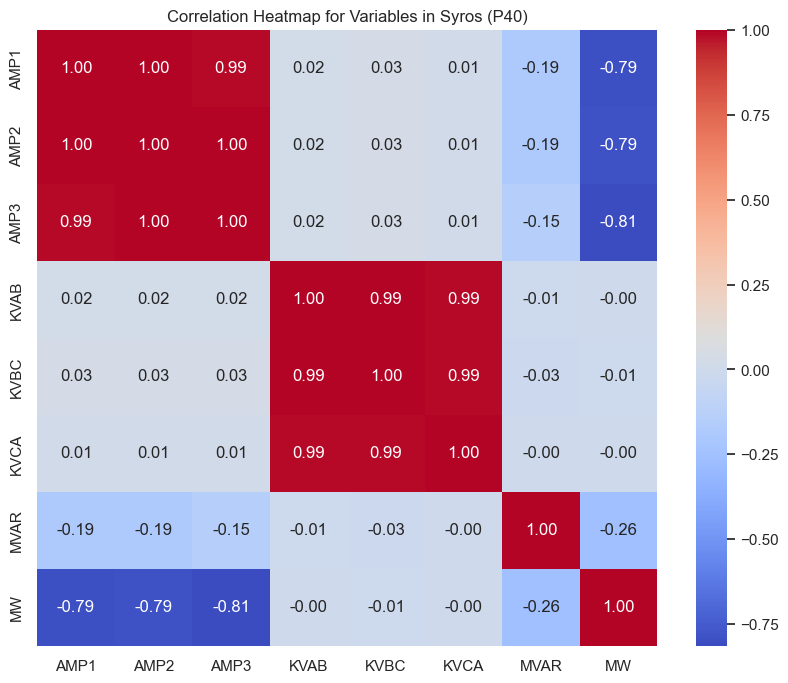


--- P60 DataFrame Correlation Analysis ---


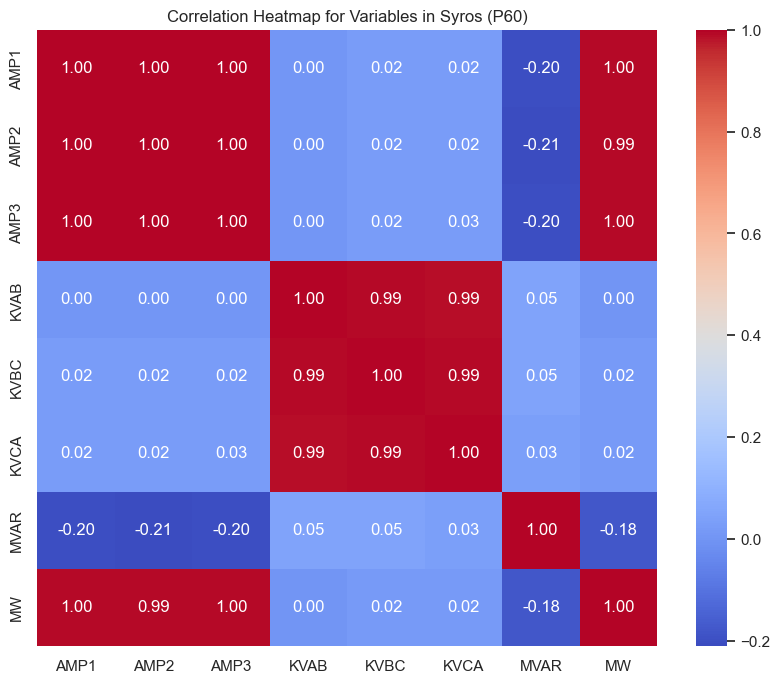


--- P70 DataFrame Correlation Analysis ---


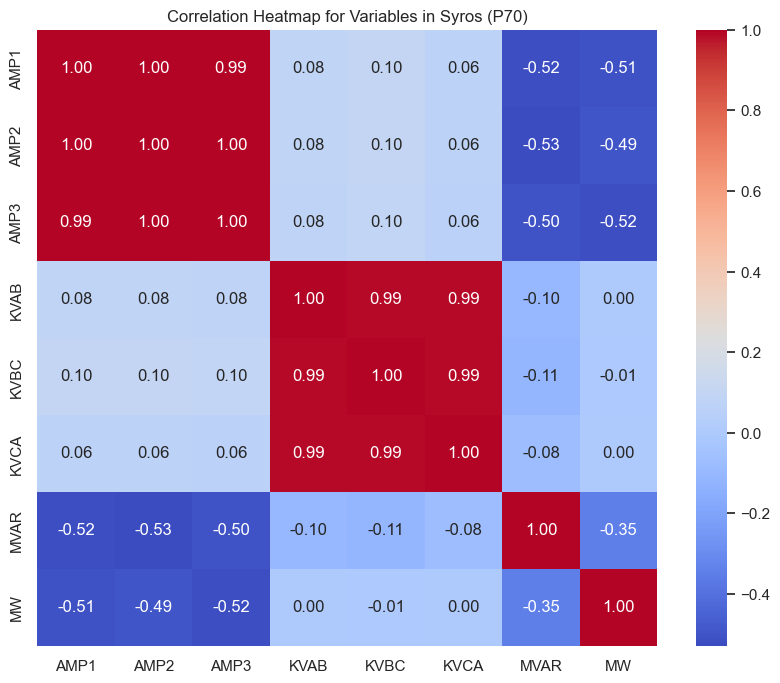

In [ ]:
print("\n--- P40 DataFrame Correlation Analysis ---")
correlation_matrix_df_p40 = df_p40.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_df_p40, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for Variables in Syros (P40)")
plt.show()

print("\n--- P60 DataFrame Correlation Analysis ---")
correlation_matrix_df_p60 = df_p60.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_df_p60, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for Variables in Syros (P60)")
plt.show()

print("\n--- P70 DataFrame Correlation Analysis ---")
correlation_matrix_df_p70 = df_p70.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_df_p70, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for Variables in Syros (P70)")
plt.show()



**P40 Correlation Conclusions**  
- Generation Confirmed: The strong negative correlation (approx. -0.8) between Power (MW) and Current (AMPs) confirms this is a generation plant. As output current rises, the power value becomes more negative (generation increases).
- Balanced & Stable System: Near-perfect correlations within the AMP and KV groups indicate a balanced three-phase system connected to a stable grid.
- Strong Grid Connection: The negligible correlation between voltage and power suggests a robust grid that is unaffected by the plant's output.

**P60 Correlation Conclusions**  
- Consumption Confirmed: The perfect positive correlation (approx. +1.00) between Power (MW) and Current (AMPs) is definitive proof that P60 is a consumer. As the current draw increases, so does the power consumed.
- Balanced Load: Similar to P40, high internal correlations show the load is balanced and connected to a stable grid.

**P70 Correlation Conclusions**  
- Generation Confirmed: The clear negative correlation (approx. -0.5) between MW and AMPs again confirms this is a generation plant.
- Different Behavior: This correlation is weaker than in P40, suggesting different operational characteristics, possibly related to its inverters or reactive power control strategy.
- Stronger MVAR Influence: The relationship between reactive power (MVAR) and active power/current is stronger in P70 than in the other facilities, indicating reactive power management is more integral to its operation.

### 5.5. Temporal Pattern Analysis

We add time-based columns to analyze consumption patterns throughout the day, week, and year.


In [152]:
# Add temporal features for analysis
df_p40['hour'] = df_p40.index.hour
df_p40['day_of_week'] = df_p40.index.dayofweek  
df_p40['month'] = df_p40.index.month

# Add temporal features for analysis
df_p60['hour'] = df_p60.index.hour
df_p60['day_of_week'] = df_p60.index.dayofweek 
df_p60['month'] = df_p60.index.month

# Add temporal features for analysis
df_p70['hour'] = df_p70.index.hour
df_p70['day_of_week'] = df_p70.index.dayofweek  
df_p70['month'] = df_p70.index.month

C:\Users\anaeg\AppData\Local\Temp\ipykernel_25216\3310098986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p40['hour'] = df_p40.index.hour
C:\Users\anaeg\AppData\Local\Temp\ipykernel_25216\3310098986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p40['day_of_week'] = df_p40.index.dayofweek
C:\Users\anaeg\AppData\Local\Temp\ipykernel_25216\3310098986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

**Daily Consumption Pattern (MW)**


--- P40 Daily Consumption Pattern (MW) ---


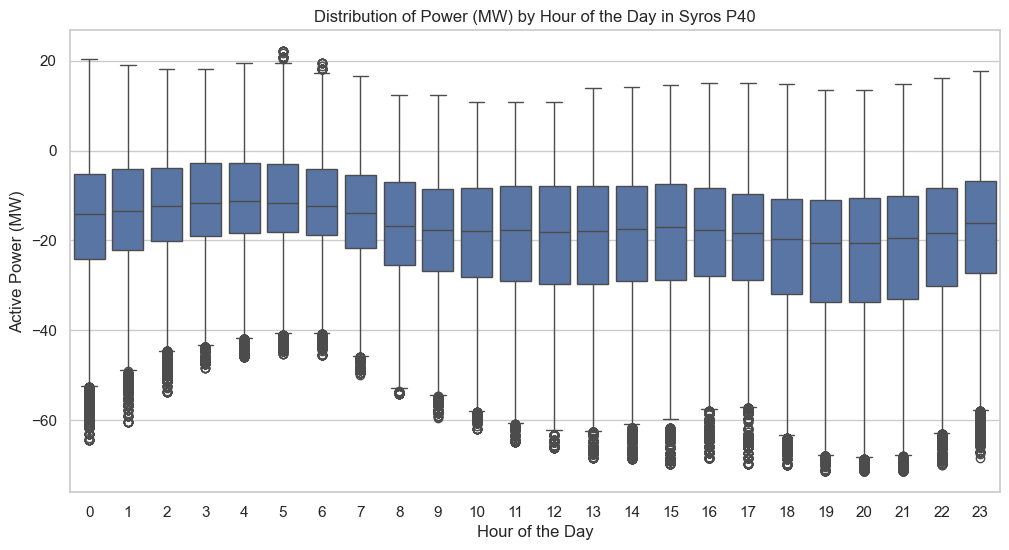


--- P60 Daily Consumption Pattern (MW) ---


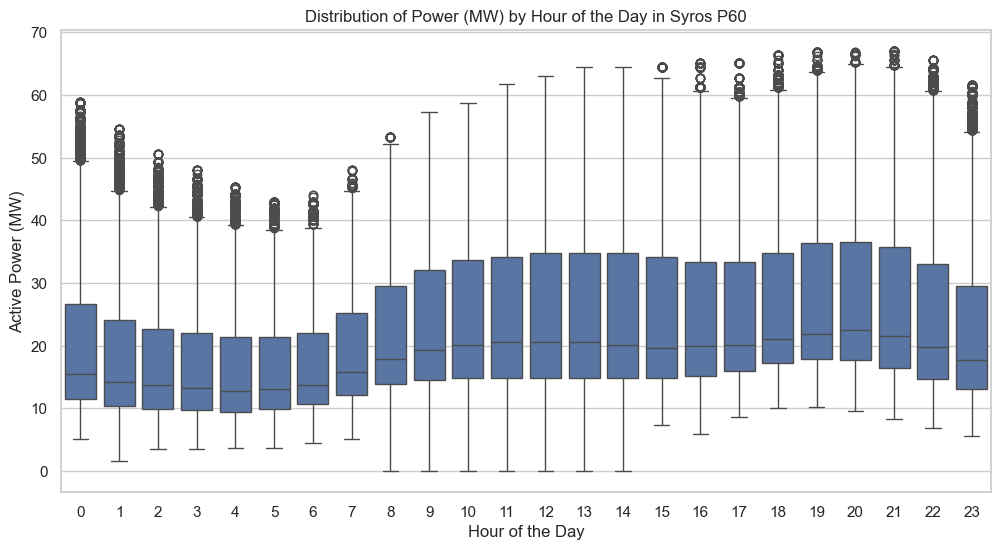


--- P70 Daily Consumption Pattern (MW) ---


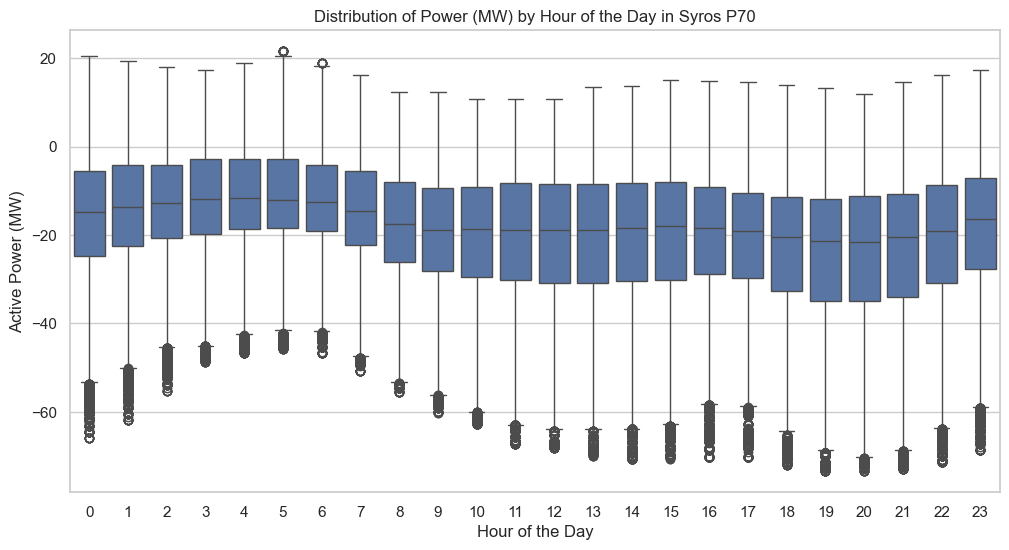

In [153]:
print("\n--- P40 Daily Consumption Pattern (MW) ---")
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='MW', data=df_p40)
plt.title("Distribution of Power (MW) by Hour of the Day in Syros P40")
plt.xlabel("Hour of the Day")
plt.ylabel("Active Power (MW)")
plt.show()

print("\n--- P60 Daily Consumption Pattern (MW) ---")
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='MW', data=df_p60)
plt.title("Distribution of Power (MW) by Hour of the Day in Syros P60")
plt.xlabel("Hour of the Day")
plt.ylabel("Active Power (MW)")
plt.show()

print("\n--- P70 Daily Consumption Pattern (MW) ---")
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='MW', data=df_p70)
plt.title("Distribution of Power (MW) by Hour of the Day in Syros P70")
plt.xlabel("Hour of the Day")
plt.ylabel("Active Power (MW)")
plt.show()

**P40 Analysis**  
A clear daily generation pattern is observed. 

**P60 Analysis**  
A clear daily consumption pattern is observed

**P70 Analysis**  
A clear daily generation pattern is observed. 

**Weekly Consumption Pattern (MW)**


--- P40 Daily Consumption Pattern (MW) ---


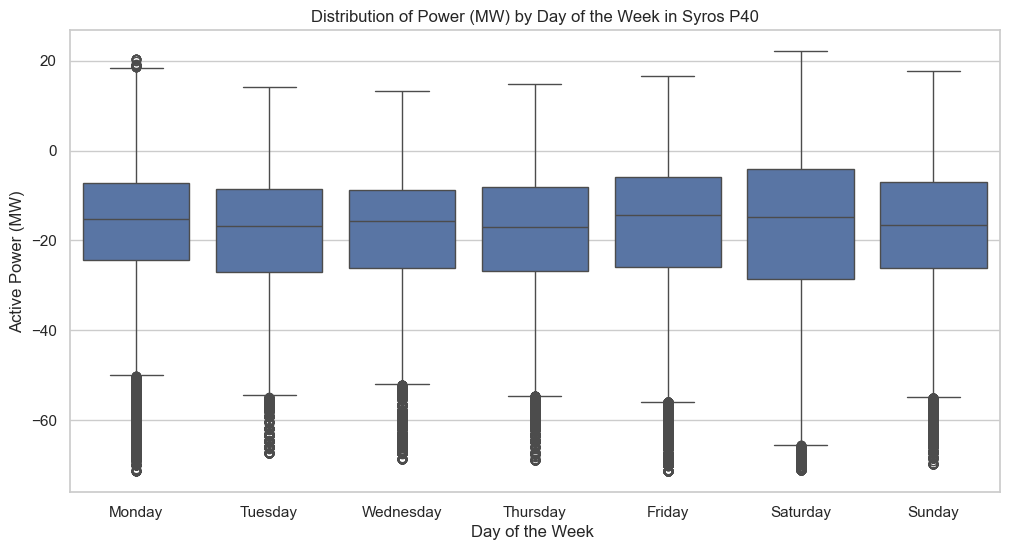


--- P60 Daily Consumption Pattern (MW) ---


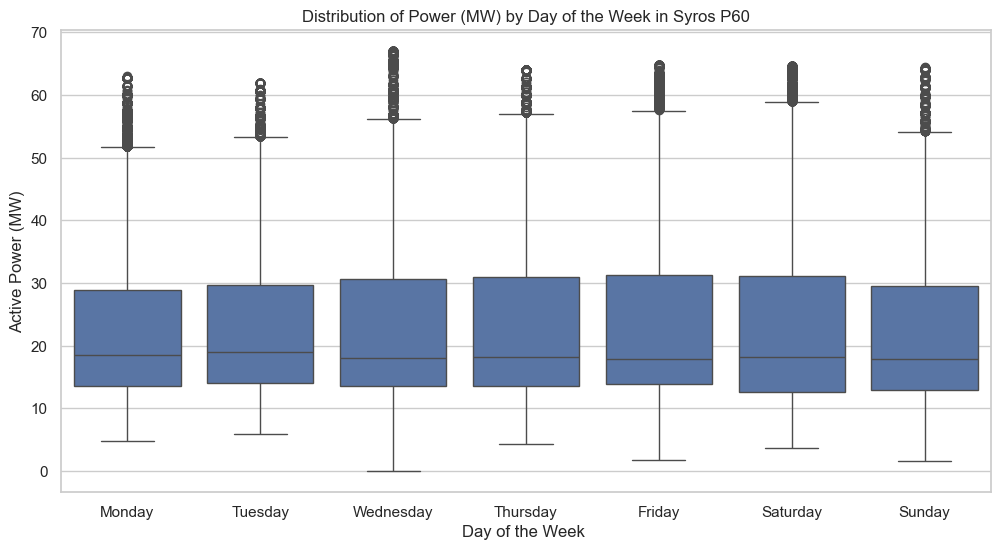


--- P70 Daily Consumption Pattern (MW) ---


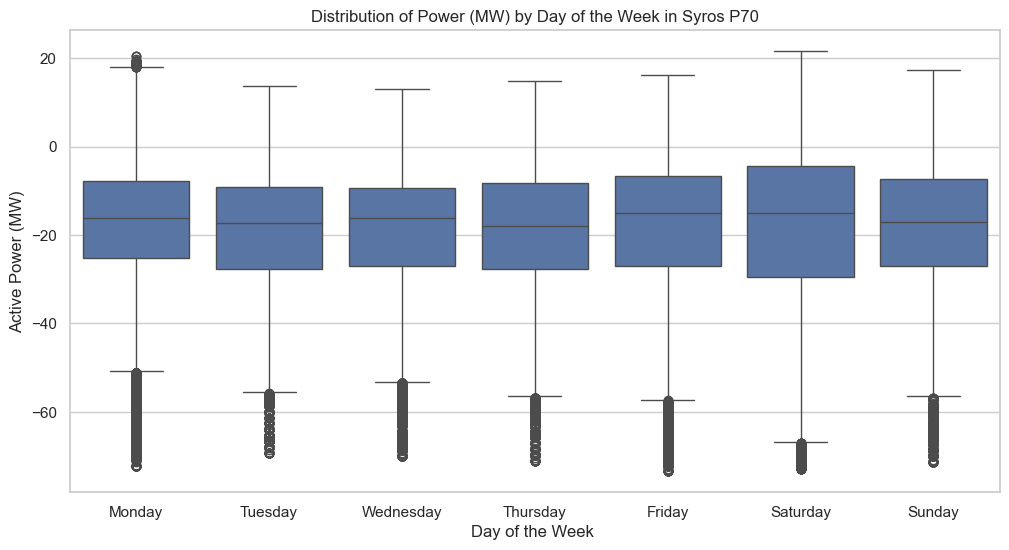

In [ ]:
print("\n--- P40 Daily Consumption Pattern (MW) ---")
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='MW', data=df_p40)
plt.title("Distribution of Power (MW) by Day of the Week in Syros P40")
plt.xlabel("Day of the Week ")
plt.ylabel("Active Power (MW)")
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

print("\n--- P60 Daily Consumption Pattern (MW) ---")
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='MW', data=df_p60)
plt.title("Distribution of Power (MW) by Day of the Week in Syros P60")
plt.xlabel("Day of the Week ")
plt.ylabel("Active Power (MW)")
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

print("\n--- P70 Daily Consumption Pattern (MW) ---")
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='MW', data=df_p70)
plt.title("Distribution of Power (MW) by Day of the Week in Syros P70")
plt.xlabel("Day of the Week ")
plt.ylabel("Active Power (MW)")
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

**P40 Analysis**  
Energy generation is relatively constant throughout the week.

**P60 Analysis**  
Consumption is relatively constant throughout the week, with no significant differences between weekdays and weekends.

**P70 Analysis**  
Energy generation is relatively constant throughout the week.

### 5.6. Seasonal Decomposition

To visualize the trend, seasonality, and noise components of the time series, we perform a seasonal decomposition on the daily aggregated data.



--- P40 Seasonal Decomposition ---


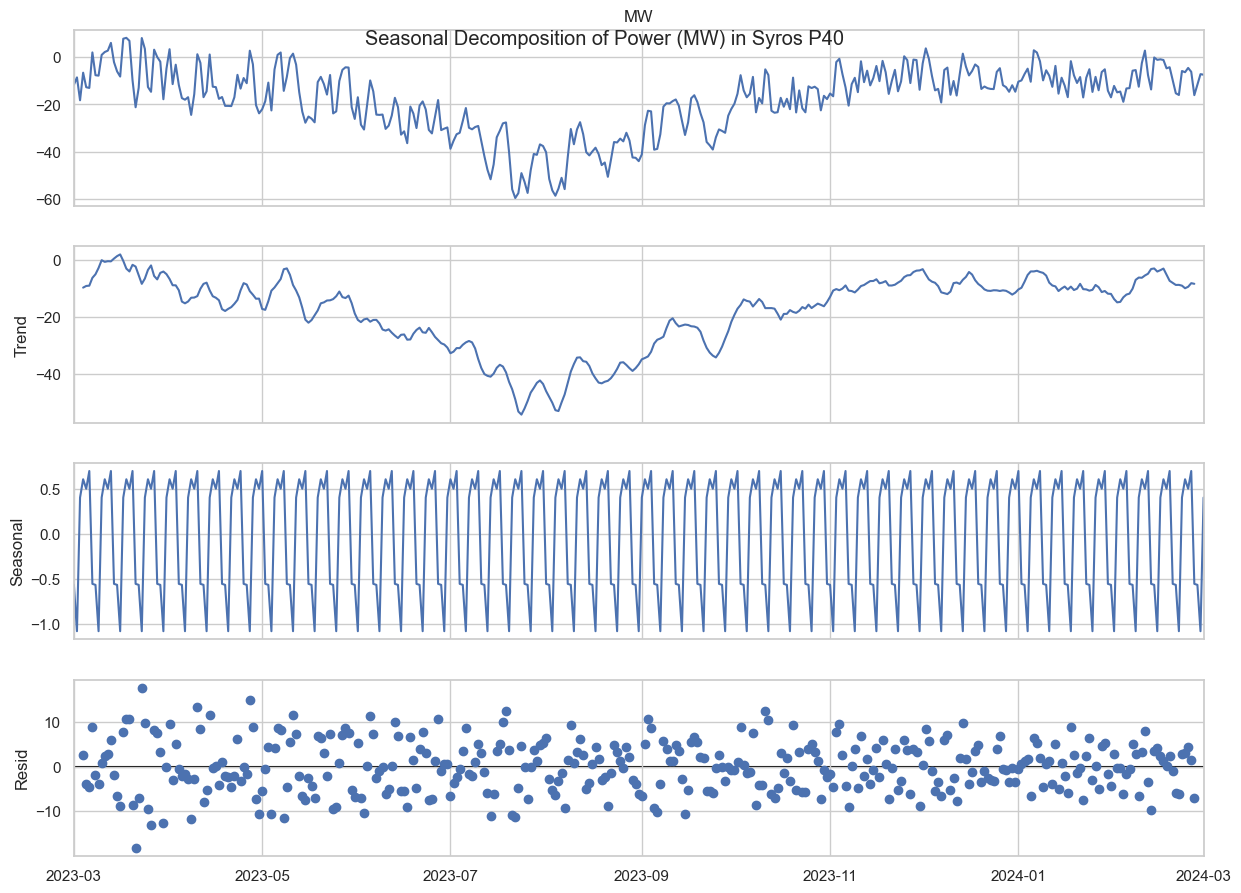


--- P60 Seasonal Decomposition ---


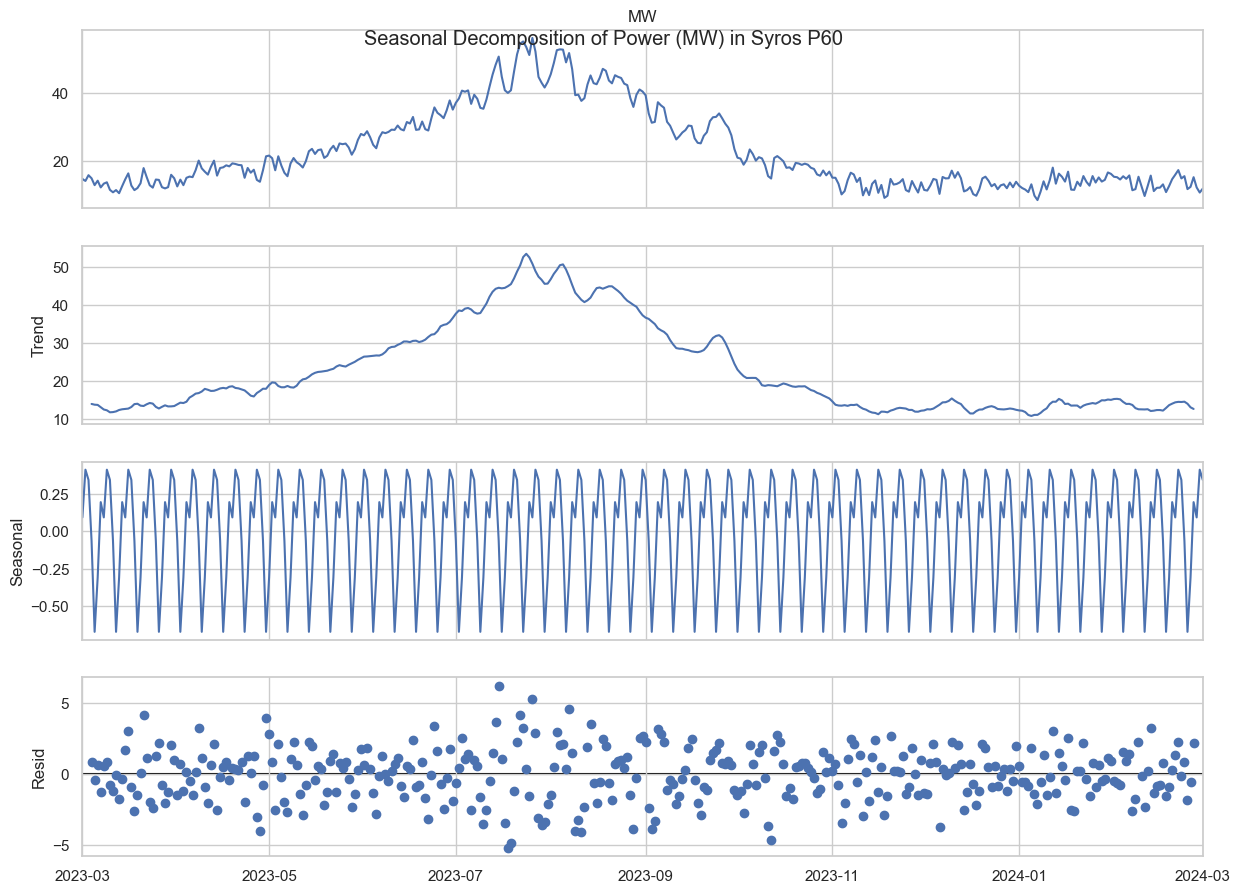


--- P70 Seasonal Decomposition ---


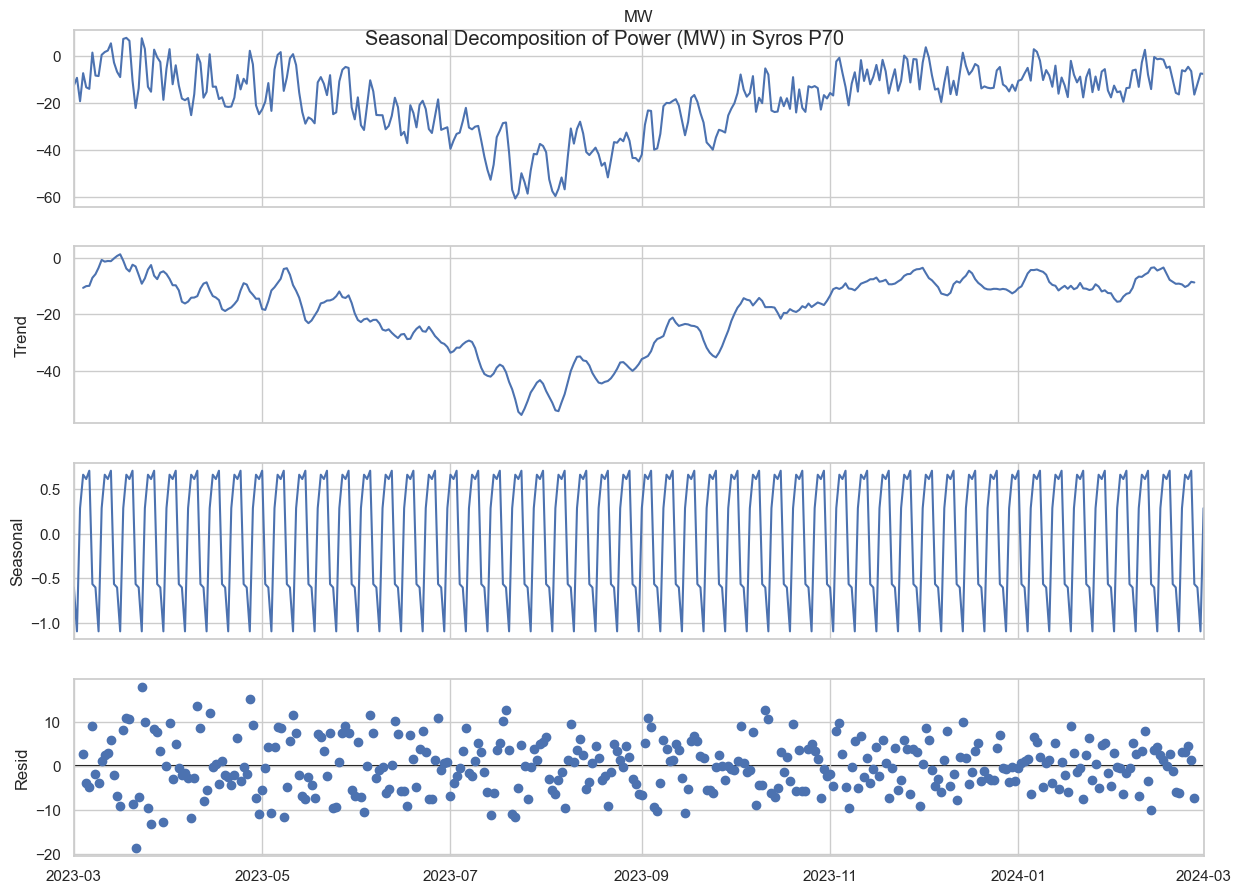

In [157]:

print("\n--- P40 Seasonal Decomposition ---")
# Resample to a daily frequency for better visualization of seasonality
df_daily_p40 = df_p40['MW'].resample('D').mean()
# Perform additive decomposition with a weekly seasonality (period=7)
decomposition_p40 = seasonal_decompose(df_daily_p40.dropna(), model='additive', period=7)
# Plot the components
fig = decomposition_p40.plot()
fig.set_size_inches(14, 10)
plt.suptitle("Seasonal Decomposition of Power (MW) in Syros P40", y=0.92)
plt.show()



print("\n--- P60 Seasonal Decomposition ---")
# Resample to a daily frequency for better visualization of seasonality
df_daily_p60 = df_p60['MW'].resample('D').mean()
# Perform additive decomposition with a weekly seasonality (period=7)
decomposition_p60 = seasonal_decompose(df_daily_p60.dropna(), model='additive', period=7)
# Plot the components
fig = decomposition_p60.plot()
fig.set_size_inches(14, 10)
plt.suptitle("Seasonal Decomposition of Power (MW) in Syros P60", y=0.92)
plt.show()



print("\n--- P70 Seasonal Decomposition ---")
# Resample to a daily frequency for better visualization of seasonality
df_daily_p70 = df_p70['MW'].resample('D').mean()
# Perform additive decomposition with a weekly seasonality (period=7)
decomposition_p70 = seasonal_decompose(df_daily_p70.dropna(), model='additive', period=7)
# Plot the components
fig = decomposition_p70.plot()
fig.set_size_inches(14, 10)
plt.suptitle("Seasonal Decomposition of Power (MW) in Syros P70", y=0.92)
plt.show()






**P40 Analysis**  
Decomposition Analysis:
- Trend: The trend reveals a clear annual cycle where power generation reaches its maximum during the summer months (June-August) and is lowest in winter. 
- Seasonal: Isolates the repeating weekly pattern of generation.
- Residuals (Resid): The residuals are relatively small and show no clear patterns, indicating that the additive model has captured the trend and seasonality well.

**P60 Analysis**  
Decomposition Analysis:
- Trend: Reveals the long-term annual consumption pattern. The trend peaks sharply in the summer months,
- Seasonal: Captures the repeating weekly consumption cycle.
- Residuals (Resid): The residuals are relatively small and show no clear patterns, indicating that the additive model has captured the trend and seasonality well.

**P70 Analysis**  
Decomposition Analysis:
- Trend: The trend reveals a clear annual cycle where power generation reaches its maximum during the summer months (June-August) and is lowest in winter. 
- Seasonal: Isolates the repeating weekly pattern of generation.
- Residuals (Resid): The residuals are relatively small and show no clear patterns, indicating that the additive model has captured the trend and seasonality well.
